In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from scipy import stats

In [130]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.sso.sso_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [131]:
from bert_transformer import BertTransformer

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)


In [132]:
X_string = 'nlp_3', # TUPLE
Y_string = 'GDT_score'
DATASET = 'NLP_CLEAN.xlsx'

In [133]:
df = pd.read_excel(io=DATASET)
df = df[df['time'] > 300]
df = df[df['label'] != 1]
# df = df[df['age'] > 30]
# df = df[df['is_male'] == 1]

for item in [f'nlp_{i}' for i in range(2, 6)]:
    df = df[df[item].apply(lambda x: len(x) > 10)]
    print(len(df))

df = df.reset_index()

468
460
449
433


In [134]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string].values
X.shape


nlp_2 added to list


(433, 768)

In [135]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

for item in [f'nlp_{i}' for i in range(2, 6)]:
    pilot_df = pilot_df[pilot_df[item].apply(lambda x: len(x) > 10)]
    print(len(pilot_df))

pilot_df = pilot_df.reset_index()

95
94
92
91


In [136]:
pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string].values
pilot_X.shape

nlp_2 added to list


(91, 768)

In [137]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.utils import class_weight

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [138]:
true_data = []
keras_results = []

for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    model = tf.keras.Sequential([
                            # tf.keras.layers.LSTM(64, input_shape=(3072, 1)),

                            # tf.keras.layers.Conv1D(32, (3,), activation='relu', input_shape=(3072, 1)),
                            # tf.keras.layers.MaxPooling1D(),
                            # tf.keras.layers.Flatten(),
                            # tf.keras.layers.Dense(units=1)


                            # tf.keras.layers.Conv1D(64, (3,), activation='sigmoid', input_shape=(3072, 1)),


                            tf.keras.layers.Dense(64, activation='sigmoid',
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.1),),
                            tf.keras.layers.Dropout(0.1),
                            tf.keras.layers.Dense(64, activation='relu'),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(units=1)
                            ])


    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9), loss='mean_absolute_error')

    model.fit(X_train, y_train, batch_size=64, epochs=200, verbose=0)
    result = model.predict(X_test)

    result = [float(item) for item in result]
    keras_results = np.concatenate((keras_results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))
    print(stats.pearsonr(keras_results, true_data))


2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.1991116481297339, pvalue=0.19506022770517495)
PearsonRResult(statistic=0.1991116481297339, pvalue=0.19506022770517495)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.2089970480300248, pvalue=0.17335260636875235)
PearsonRResult(statistic=0.15085725018627172, pvalue=0.16062417368005236)
2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.42204507513132233, pvalue=0.004322836360073068)
PearsonRResult(statistic=0.22081190829446048, pvalue=0.01094992100741727)
2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.45196097983000033, pvalue=0.002346130222443953)
PearsonRResult(statistic=0.2747541002772908, pvalue=0.0002335264660751233)
2/2 [==============================] - 0s 8ms/step
PearsonRResult(statistic=0.3122210611349695, pvalue=0.04151904823148189)
PearsonRResult(statistic=0.2841368289397858, pvalue=2.0513455348537747e-05)
2/2 [=

In [152]:
from sklearn import svm

SVR_function = svm.SVR(kernel='poly', C=1.2, tol=1e-3)
# SVR_function = svm.SVR(kernel='poly', degree=8, C=4.9)

svr_results = []


for train_index, test_index in kfold.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

   
    vector_regression = SVR_function
    vector_regression.fit(X_train, y_train)
    svr_result = vector_regression.predict(X_test)

    svr_results = np.concatenate((svr_results, svr_result))

stats.pearsonr(svr_results, true_data)

PearsonRResult(statistic=0.2568824072304303, pvalue=5.921318199949357e-08)

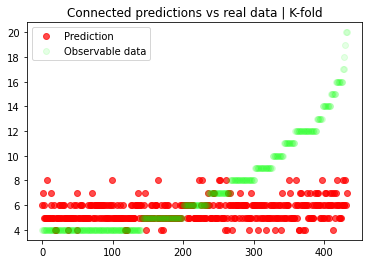

PearsonRResult(statistic=0.2772025598921432, pvalue=4.440174682357064e-09)


In [153]:
#WHOLE DATASET

connected_results = [(p_1 + p_2) / 2 for p_1, p_2 in zip(svr_results, keras_results)]

changed_connected_results = [item if item >= 4 else 4 for item in connected_results]
changed_results = [item if item <= 20 else 20 for item in changed_connected_results]

answers_tuples = [(y, res) for y, res in zip(true_data, changed_results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

sorted_true_data = [x[0] for x in sorted_tuples]
sorted_results = [x[1] for x in sorted_tuples]

rounded_connected_results = [round(int(item)) for item in sorted_results]

plt.plot(range(len(rounded_connected_results)), rounded_connected_results, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(sorted_true_data)), sorted_true_data, 'o', color=[0, 1, 0, 0.1], label='Observable data')
plt.legend(loc='upper left')
plt.title('Connected predictions vs real data | K-fold')
plt.show()

print(stats.pearsonr(connected_results, true_data))

In [154]:
# Using model to predict pilot data

model = tf.keras.Sequential([
                        # tf.keras.layers.LSTM(64, input_shape=(None, 1)),
                        # tf.keras.layers.Conv1D(32, (3,), activation='relu', input_shape=(3072, 1)),
                        # tf.keras.layers.MaxPooling1D(),
                        # tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(64, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                        tf.keras.layers.Dense(32, activation='relu'),
                        tf.keras.layers.Flatten(),
                        tf.keras.layers.Dense(units=1)
                        ])
                        
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
model.fit(X, y, batch_size=64, epochs=100, verbose=0)

3/3 [==============================] - 0s 0s/step


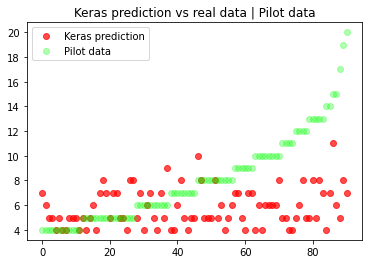

In [155]:
keras_pilot_prediction = model.predict(pilot_X)
keras_pilot_prediction = [float(item) for item in keras_pilot_prediction]
keras_pilot_results = [item if item >= 4 else 4 for item in keras_pilot_prediction]
keras_pilot_results = [item if item <= 20 else 20 for item in keras_pilot_results]

answers_tuples = [(y, res) for y, res in zip(pilot_Y, keras_pilot_results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
keras_pilot_changed = [x[1] for x in sorted_tuples]

keras_pilot_rounded = [round(int(item)) for item in keras_pilot_changed]

plt.plot(range(len(keras_pilot_rounded)), keras_pilot_rounded, 'o', color=[1, 0, 0, 0.7], label="Keras prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Keras prediction vs real data | Pilot data')
plt.show()

In [156]:
svr_pilot_prediction = SVR_function.predict(pilot_X)
svr_pilot_results = [item if item >= 4 else 4 for item in svr_pilot_prediction]
svr_pilot_results = [item if item <= 20 else 20 for item in svr_pilot_results]

In [157]:
CONNECTED_K_FOLD = stats.pearsonr(connected_results, true_data)
CONNECTED_K_FOLD_MAE = round(mean_absolute_error(true_data, connected_results), 2)

KERAS_K_FOLD = stats.pearsonr(keras_results, true_data)
KERAS_K_FOLD_MAE = round(mean_absolute_error(true_data, keras_results), 2)

SVR_K_FOLD = stats.pearsonr(svr_results, true_data)
SVR_K_FOLD_MAE = round(mean_absolute_error(true_data, svr_results), 2)

connected_pilot_results = [(p_1 + p_2) / 2 for p_1, p_2 in zip(svr_pilot_results, keras_pilot_results)]

CONNECTED_EVAL = stats.pearsonr(connected_pilot_results, pilot_Y)
CONNECTED_EVAL_MAE = round(mean_absolute_error(connected_pilot_results, pilot_Y), 2)

KERAS_EVAL = stats.pearsonr(keras_pilot_results, pilot_Y)
KERAS_EVAL_MAE = round(mean_absolute_error(keras_pilot_results, pilot_Y), 2)

SVR_EVAL = stats.pearsonr(svr_pilot_results, pilot_Y)
SVR_EVAL_MAE = round(mean_absolute_error(svr_pilot_results, pilot_Y), 2)

SVR_C = SVR_function.C

In [159]:
from openpyxl.workbook import Workbook
from openpyxl import load_workbook


workbook_name = 'results.xlsx'
wb = load_workbook(workbook_name)
ws = wb.active

i = ws.max_row + 1
ws[f'A{i}'] = str(X_string)
ws[f'B{i}'] = SVR_C
ws[f'C{i}'] = f'{round(SVR_K_FOLD[0], 4)} ({round(SVR_K_FOLD[1], 4)})'
ws[f'D{i}'] = SVR_K_FOLD_MAE
ws[f'E{i}'] = f'{round(KERAS_K_FOLD[0], 4)} ({round(KERAS_K_FOLD[1], 4)})'
ws[f'F{i}'] = KERAS_K_FOLD_MAE
ws[f'G{i}'] = f'{round(CONNECTED_K_FOLD[0], 4)} ({round(CONNECTED_K_FOLD[1], 4)})'
ws[f'H{i}'] = CONNECTED_K_FOLD_MAE
ws[f'I{i}'] = f'{round(SVR_EVAL[0], 4)} ({round(SVR_EVAL[1], 4)})'
ws[f'J{i}'] = SVR_EVAL_MAE
ws[f'K{i}'] = f'{round(KERAS_EVAL[0], 4)} ({round(KERAS_EVAL[1], 4)})'
ws[f'L{i}'] = KERAS_EVAL_MAE
ws[f'M{i}'] = f'{round(CONNECTED_EVAL[0], 4)} ({round(CONNECTED_EVAL[1], 4)})'
ws[f'N{i}'] = CONNECTED_EVAL_MAE

wb.save("results.xlsx")